In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
import time
import tifffile
import matplotlib.pyplot as plt
!pip install sewar
from PIL import Image
import skimage.measure  
import skimage.measure
import pywt
from math import log10, sqrt
import cv2
import numpy as np
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb 

from sklearn.decomposition import PCA
  



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/ProjectWork')

In [ ]:
#@title
from abc import abstractmethod
import numpy as np
from math import pi
from cv2 import cartToPolar, Sobel, CV_32F
from matplotlib.pyplot import imshow, title, show

class XideaPetrovicMetric():
    # xydeas_petrovic parameters
    # The constants Γ, κ , σ  and Γα, κα, σα determine 
    # the  exact  shape  of  the  sigmoid  functions  used  to  form  the  edge  strength  and  
    # orientation  preservation  values.
    def __init__(self, image1, image2, fusedImage) -> None:
        self.EPS = np.finfo(float).eps
        self.GAMMA1 = 1
        self.GAMMA2 = 1
        self.K1 = -10
        self.K2 = -20
        self.DELTA1 = 0.5
        self.DELTA2 = 0.75
        self.L = 1
        self.image1 = image1
        self.image2 = image2
        self.fusedImage = fusedImage

    def _sobel_edge_detection(self, image, verbose=False):
        sx = Sobel(image, CV_32F, 1, 0)
        sy = Sobel(image, CV_32F, 0, 1)

        if verbose:
            imshow(sx, cmap='gray')
            title("Horizontal Edge")
            show()

            imshow(sy, cmap='gray')
            title("Vertical Edge")
            show()

        return cartToPolar(sx, sy)

    def _strenght_n_orientation(self, image):
        #The first input is the source image, which we convert to float. 
        #The second input is the output image, but we'll set that to None as we want the function 
        # call to return that for us. 
        #The third and fourth parameters specify the minimum and maximum values 
        # you want to appear in the output, which is 0 and 1 respectively, 
        #and the last output specifies how you want to normalize the image.
        # What I described falls under the NORM_MINMAX flag.
        #image = normalize(image.astype('float'), None, 0.0, 1.0, NORM_MINMAX)  
        # Kernels for convolving over the images
        #flt1= [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
        #flt2= [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
        # 1) get the map Sobel operator
        #fuseX = filter2D(image, -1, flt1)
        #fuseY = filter2D(image, -1, flt2)
        #   EQUIVALENT TO:
        s_x, s_y = self._sobel_edge_detection(image)
        #fusex
        # A Sobel edge operator is applied to yield the edge strength G
        g = np.sqrt(s_x**2 + s_y**2)
        # Orientation α(n,m) information for each pixel p
        alpha = np.arctan(s_y / ( s_x + self.EPS))
        return (g, alpha)

    def _perceptual_loss(self, gA, gF, alphaA, alphaF):
        # If g o alpha are followed by an underscore are ment to be considered written in uppercase
        # The relative strength and orientation values of g_AF(n,m) and alpha_AF(n,m) of an input 
        # image A with respect to F are formed as:
        
        #x, y = gA.shape
        #g_AF = np.zeros((x,y))
        #for n in range(x):
        #    for m in range(y):
        #        if (gA[n][m]  > gF[n][m]):
        #            g_AF[n][m] = gF[n][m] / ( gA[n][m] + EPS)
        #        else:
        #            g_AF[n][m] = gA[n][m] / ( gF[n][m] + EPS)
        bmap0 = gA > gF
        bmap1 = gA < gF
        
        g_AF0 = np.divide(gF, ( gA + self.EPS))
        g_AF1 = np.divide(gA, ( gF + self.EPS))

        g_AF = np.multiply(bmap0, g_AF0) + np.multiply(bmap1, g_AF1)

        alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)

        qG_AF = self.GAMMA1 / (1 + np.exp( self.K1 *(g_AF - self.DELTA1)))
        qalpha_AF = self.GAMMA2 / (1 + np.exp( self.K2 *(alpha_AF - self.DELTA2) ))
        # These are used to derive the edge strength and orientation preservation values
        # QgAF(n,m)  and  QαAF(n,m)  model  perceptual  loss  of  information  in  F,  in  terms  of  
        # how well the strength and orientation values of a pixel p(n,m) in A are 
        # represented in the fused image. 
        #
        # Edge  information preservation values are then defined as
        q_AF = qG_AF * qalpha_AF
        # with  0  ≤  Q AF(n,m)  ≤  1 .  A  value  of  0  corresponds  to  the  complete  loss  of  edge  
        # information, at location (n,m), as transferred from A into F. QAF(n,m)=1 indicates 
        # “fusion” from A to F with no loss of information. 
        return q_AF

    def calculate(self):
        # EDGE Strenght and orientation for each pixels of the input images
        gA, alphaA = self._strenght_n_orientation(self.image1)
        gB, alphaB = self._strenght_n_orientation(self.image2)
        gF, alphaF = self._strenght_n_orientation(self.fusedImage)
        
        self.q_AF = self._perceptual_loss(gA, gF, alphaA, alphaF)
        self.q_BF = self._perceptual_loss(gB, gF, alphaB, alphaF)
        #
        # In general edge preservation values which 
        # correspond to pixels with high edge strength, should influence normalised weighted  
        # performance metric QP more than 
        # those of relatively low edge strength.Thus, wA(n,m)=[gA(n,m)]^L and 
        # wB(n,m)=[gB(n,m)]^L where L is a constant.
        #
        self.wA = gA #np.linalg.matrix_power(gA, L)
        self.wB = gB #np.linalg.matrix_power(gB, L)

        self.r = ( gF < gA ) | ( gF < gB )
        self.bitmap_artifacts = (gF > gA) & (gF > gB)

        return self.metric() #hook
    
    @abstractmethod
    def metric(self):
        pass

class InformationPreservation(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        qP_ABF = sum( sum((self.q_AF * self.wA + self.q_BF * self.wB))) / sum ( sum((self.wA + self.wB)))
        return qP_ABF

class TotalFusionGain(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    def metric(self):
        # local exclusive information in F, Q_delta
        # quantifies the total amount of local
        # exclusive information across the fused image.
    
        q_delta = np.abs(self.q_AF - self.q_BF)
    
        # For locations with strong correlation between the inputs Q_delta 
        # will be small or zero, indicating no exclusive
        # information. Conversely, in areas where one of the
        # inputs provides a meaningful feature that is not present
        # in the other this quantity will tend towards 1.

        # The common information component for all locations across the fused image
        q_common = (self.q_AF + self.q_BF  - q_delta) / 2
        # ½ is introduced as common information is contained in both Q_AF and Q_BF

        # Local estimates of exclusive information
        # components of each input
        q_delta_AF = self.q_AF - q_common
        # is the proportion of useful information fused in F that exists only in A
        q_delta_BF = self.q_BF - q_common
        # is the proportion of useful information fused in F that exists only in B

        # These quantities represent effectively, local fusion gain 
        # achieved by fusing A and B with respect to each individual {A, B}.
        
        # TOTAL FUSION GAIN
        return sum( sum((q_delta_AF * self.wA + q_delta_BF * self.wB))) / sum ( sum((self.wA + self.wB)))

class FusionLossArtifact(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        # if gradient strength in F is larger than
        # that in the inputs, F contains artifacts; conversely, a
        # weaker gradient in F indicates a loss of input
        # information.
        loss = np.multiply(1 - self.q_AF, self.wA) + np.multiply(1 - self.q_BF, self.wB)
        loss = np.multiply(loss, self.r)
        loss = sum( sum(loss)) / sum ( sum((self.wA + self.wB)))

        #Artifacts calculation
        
        artifacts = 2 - self.q_AF - self.q_BF
        artifacts = np.multiply(self.bitmap_artifacts, artifacts)
        artifacts = sum( sum(artifacts)) / sum ( sum((self.wA + self.wB)))

        return (loss, artifacts)


In [ ]:
def read_img(pan_test_path, ms_test_path, img_name, FLAGS):
    pan_img_path=os.path.join(pan_test_path, img_name)
    ms_img_path=os.path.join(ms_test_path, img_name)
    #pan_img=cv2.imread(pan_img_path, -1)
    #pan_img=gdal_read(pan_img_path,'pan')
    pan_img=read8bit(pan_img_path,'pan')
    h,w=pan_img.shape
    pan_img=pan_img.reshape((1,h,w,1))
    #ms_img=cv2.imread(ms_img_path, -1)
    #ms_img=gdal_read(ms_img_path,'ms')
    ms_img=read8bit(ms_img_path,'ms')
    h,w,c=ms_img.shape
    ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    h,w,c=ms_img.shape
    
    # ms_img=np.array(ms_img)
    # h,w,c=ms_img.shape
    # ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    ms_img=ms_img.reshape((1,h,w,c))
   
    return pan_img, ms_img


In [ ]:
def gdal_read(path,name):
    data=gdal.Open(path)
    w=data.RasterXSize
    h=data.RasterYSize
    img=data.ReadAsArray(0,0,w,h)
    if name == 'ms':
        img=np.transpose(img,(1,2,0))
    img=(img-1023.5)/1023.5
    return img


In [ ]:
def read8bit(path,name):
    if name=='ms':
        v='src'
    else:
        v='pan'
    v='I'
    #img=scio.loadmat(path)[v]
    img=np.load(path)
    img=(img-127.5)/127.5
    return img


In [ ]:
def img_write(img_array,save_path):
    datatype=gdal.GDT_UInt16
    h,w,c=img_array.shape
    driver=gdal.GetDriverByName('GTiff')
    data=driver.Create(save_path, w, h, c, datatype)
    for i in range(c):
        data.GetRasterBand(i+1).WriteArray(img_array[:,:,i])
    del data


In [ ]:
def display(pan,ms,fused,size=(18,6)):
    print("fused shape",fused.shape)
    titles = ['pan','MS band 0','MS band 1','MS band 2','MS band 3','Fused']
    fig,ax = plt.subplots(nrows=1,ncols=6,figsize=size)
    ax[0].imshow(pan[0], cmap= 'gray')
    ax[1].imshow(ms[0][:,:,0], cmap= 'gist_earth')
    ax[2].imshow(ms[0][:,:,1], cmap= 'gist_earth')
    ax[3].imshow(ms[0][:,:,2], cmap= 'gist_earth')
    ax[4].imshow(ms[0][:,:,3], cmap= 'gist_earth')
    ax[5].imshow(fused, cmap= 'gist_earth')
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()
    u_ms= uqi(ms[0][:,:,:3],fused)
    print('UQI fused/MS=' ,u_ms)
    u_pan= uqi(pan[0],fused[:,:,:1])
    print('UQI fused/PAN= ',u_pan)


In [ ]:
os.listdir("data/test_gt_gf")  

['pan', 'hrms', 'lrms']

In [ ]:
def display(pan,ms,fused,size=(18,6)):
    print("fused shape",fused.shape)
    titles = ['pan','MS band 0','MS band 1','MS band 2','MS band 3','Fused']
    fig,ax = plt.subplots(nrows=1,ncols=6,figsize=size)
    ax[0].imshow(pan[0], cmap= 'gray')
    ax[1].imshow(ms[0][:,:,0], cmap= 'gist_earth')
    ax[2].imshow(ms[0][:,:,1], cmap= 'gist_earth')
    ax[3].imshow(ms[0][:,:,2], cmap= 'gist_earth')
    ax[4].imshow(ms[0][:,:,3], cmap= 'gist_earth')
    ax[5].imshow(fused, cmap= 'gist_earth')
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()
    u_ms= uqi(ms[0][:,:,:3],fused)
    print('UQI fused/MS=' ,u_ms)
    u_pan= uqi(pan[0],fused[:,:,:1])
    print('UQI fused/PAN= ',u_pan)


(456, 404, 3)
(456, 404)


<Figure size 432x432 with 0 Axes>

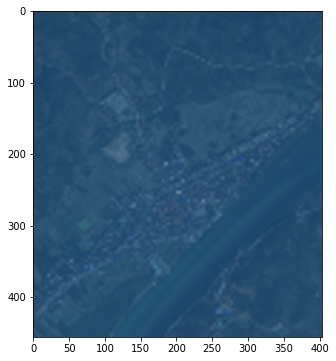

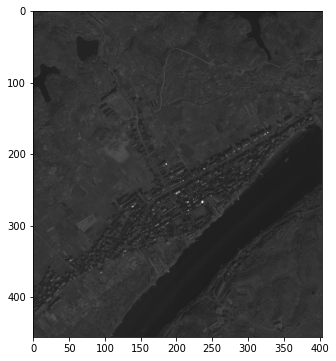

<Figure size 432x432 with 0 Axes>

In [ ]:
result1 = Image.open('/content/drive/MyDrive/ProjectWork/result/crop8bit_1.PNG')
fused= np.array(result1)
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_1.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0, cmap='gray')
print(pan0.shape)
plt.figure(figsize=(6,6))


In [ ]:
#@title
def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)
def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

PCA on MS

In [ ]:
img = cv2.imread( '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/lrms/crop8bit_1.npy')

(456, 404, 3)


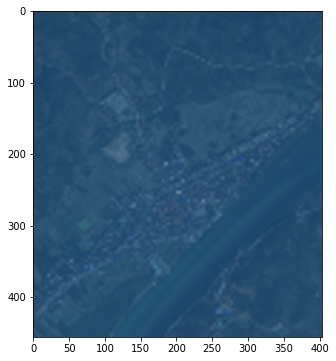

In [ ]:
#@title
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_1.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
# Displaying the image
#plt.figure(figsize=[12,8])


(456, 404, 3)
image size =  (456, 404)


Dispalying colour image of the scene
(456, 404, 3)


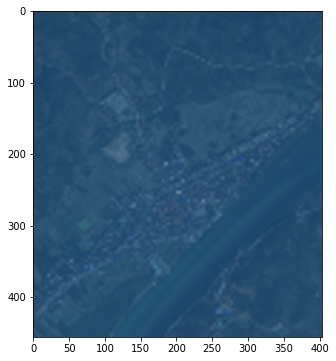

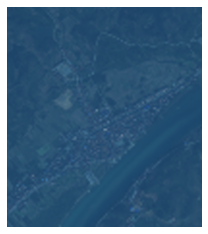

In [ ]:
#@title
# Read RGB image into an array
ms0 = cv2.imread('/content/drive/MyDrive/ProjectWork/data/test_gt_gf/lrms/crop8bit_1.npy')
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_1.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
# Displaying the image
#plt.figure(figsize=[12,8])

img_shape = ms0.shape[:2]
print('image size = ',img_shape)

# specify no of bands in the image
n_bands = 7

# 3 dimensional dummy array with zeros
MB_img = np.zeros((img_shape[0],img_shape[1],n_bands))

# stacking up images into the array
for i in range(n_bands):
    MB_img[:,:,i] = cv2.imread('band'+str(i+1)+'.jpg',
                               cv2.IMREAD_GRAYSCALE)  

# Let's take a look at scene
print('\n\nDispalying colour image of the scene')
plt.figure(figsize=(img_shape[0]/100,img_shape[1]/100))
plt.imshow(ms0)
print(ms0.shape)
plt.axis('off');

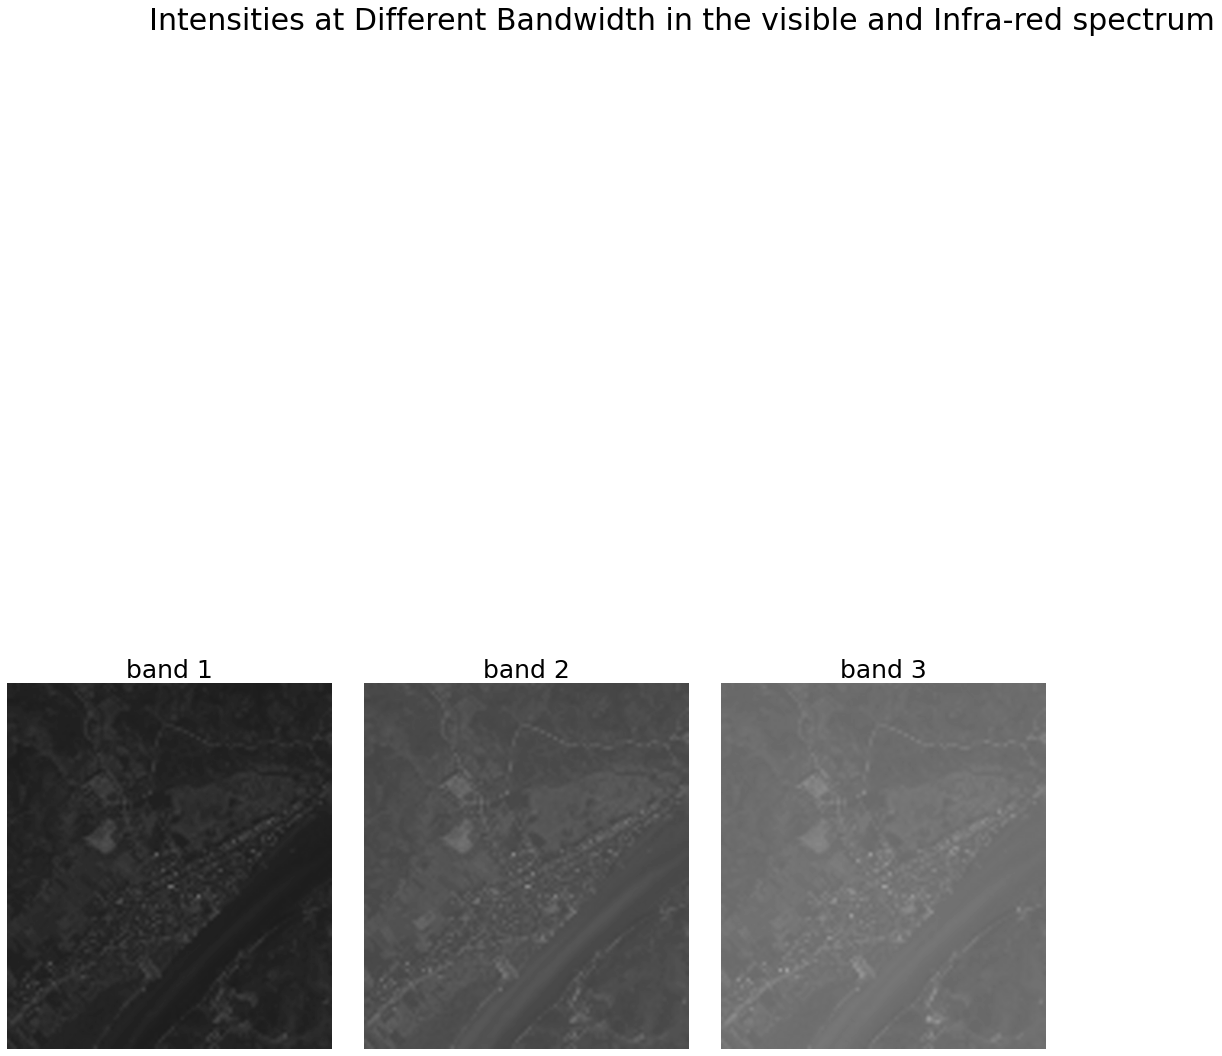

In [ ]:
#@title
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

fig,axes = plt.subplots(1,4,figsize=(25,25),sharex='all', sharey='all')
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities at Different Bandwidth in the visible and Infra-red spectrum', fontsize=30)
axes = axes.ravel()

for i in range(3):
    axes[i].imshow(ms0[:,:,i],cmap='gray', vmin=0, vmax=255)
    axes[i].set_title('band '+str(i+1),fontsize=25)
    axes[i].axis('off')
fig.delaxes(axes[-1])

In [ ]:
#@title
n_bands= 3
MB_matrix = np.zeros((ms0[:,:,0].size,n_bands))

for i in range(n_bands):
    MB_array = ms0[:,:,i].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    MB_matrix[:,i] = MB_arrayStd
MB_matrix.shape;

In [ ]:
#@title
#covariance
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)

print("Eigenvalues:\n\n", EigVal,"\n")

Eigenvalues:

 [2.78  0.167 0.053] 



In [ ]:
#@title
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix,EigVec)   #cross product

Text(0.5, 0.98, 'Pair plot of PCs')

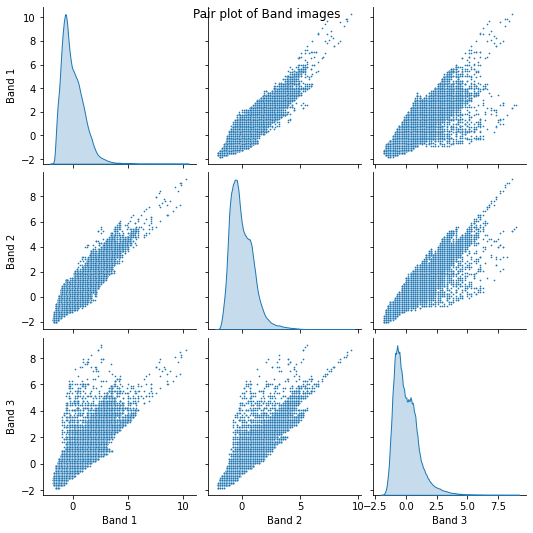

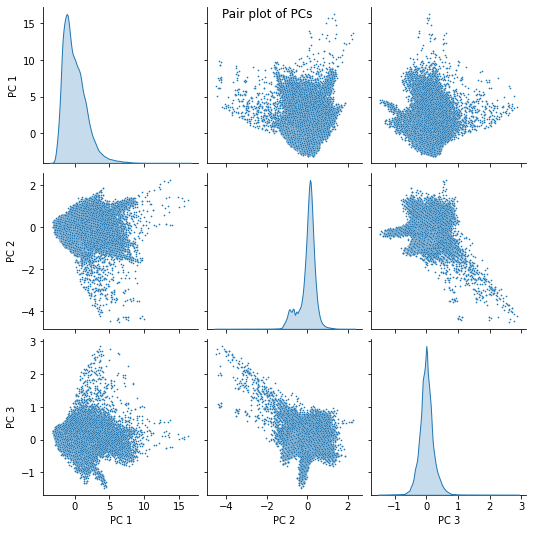

In [ ]:
#@title
# Generate Paiplot for original data and transformed PCs

Bandnames = ['Band 1','Band 2','Band 3']
a = sns.pairplot(pd.DataFrame(MB_matrix,
                columns = Bandnames),
                 diag_kind='kde',plot_kws={"s": 3})
a.fig.suptitle("Pair plot of Band images")

PCnames = ['PC 1','PC 2','PC 3']
b = sns.pairplot(pd.DataFrame(PC,
                columns = PCnames),
                 diag_kind='kde',plot_kws={"s": 3})
b.fig.suptitle("Pair plot of PCs")

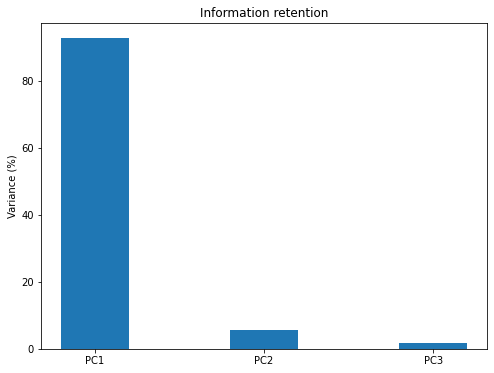

In [ ]:
#@title
#Information Retained by Principal Components

plt.figure(figsize=(8,6))
plt.bar([1,2,3],EigVal/sum(EigVal)*100,align='center',width=0.4,
        tick_label = ['PC1','PC2','PC3'])
plt.ylabel('Variance (%)')
plt.title('Information retention');

In [ ]:
#@title
PC_2d = np.zeros((img_shape[0],img_shape[1],n_bands))
for i in range(n_bands):
    PC_2d[:,:,i] = PC[:,i].reshape(-1,img_shape[1])

# normalizing between 0 to 255
PC_2d_Norm = np.zeros((img_shape[0],img_shape[1],n_bands))
for i in range(n_bands):
    PC_2d_Norm[:,:,i] = cv2.normalize(PC_2d[:,:,i],
                    np.zeros(img_shape),0,255 ,cv2.NORM_MINMAX)

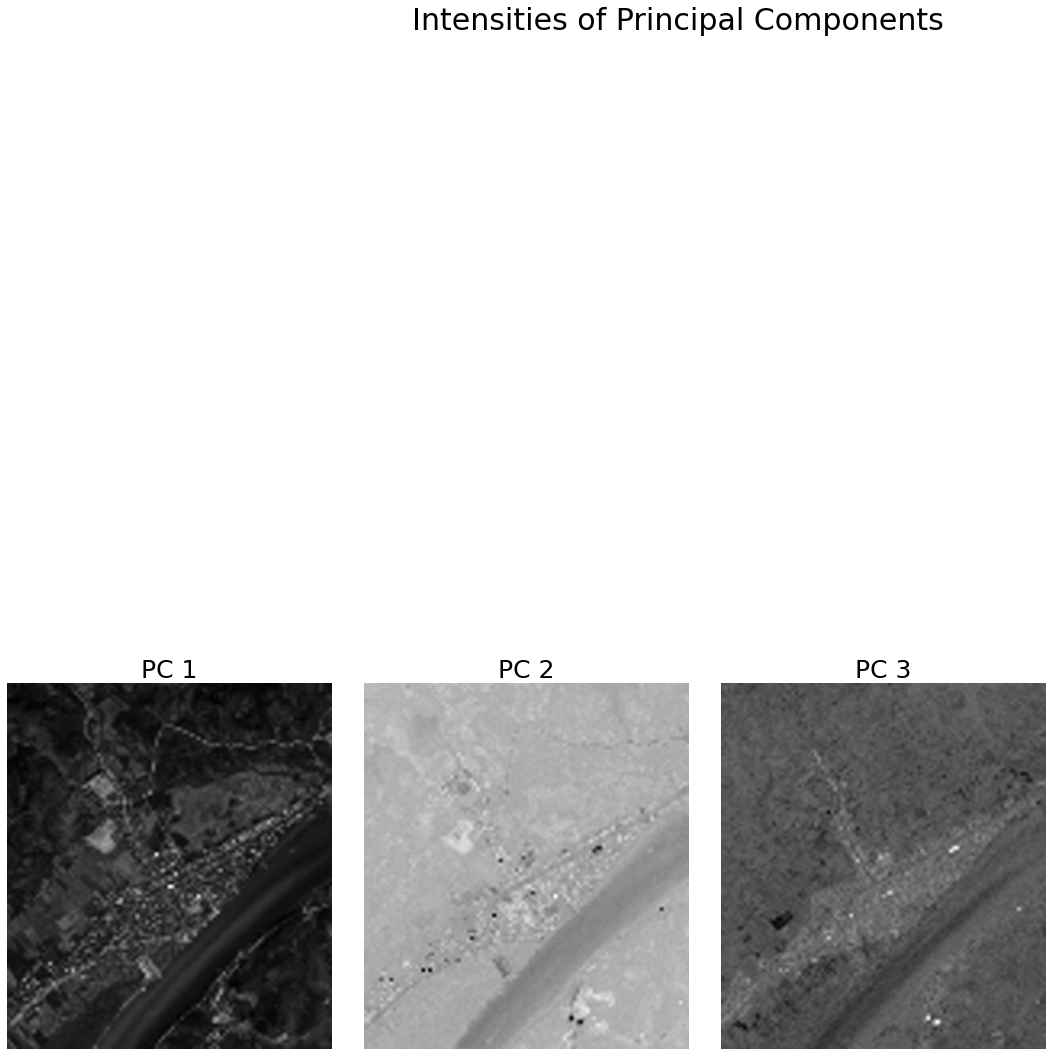

In [ ]:
#@title
fig,axes = plt.subplots(1,4,figsize=(25,25),sharex='all',
                        sharey='all')
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Intensities of Principal Components ', fontsize=30)

axes = axes.ravel()
for i in range(n_bands):
    axes[i].imshow(PC_2d_Norm[:,:,i],cmap='gray', vmin=0, vmax=255)
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')
fig.delaxes(axes[-1])

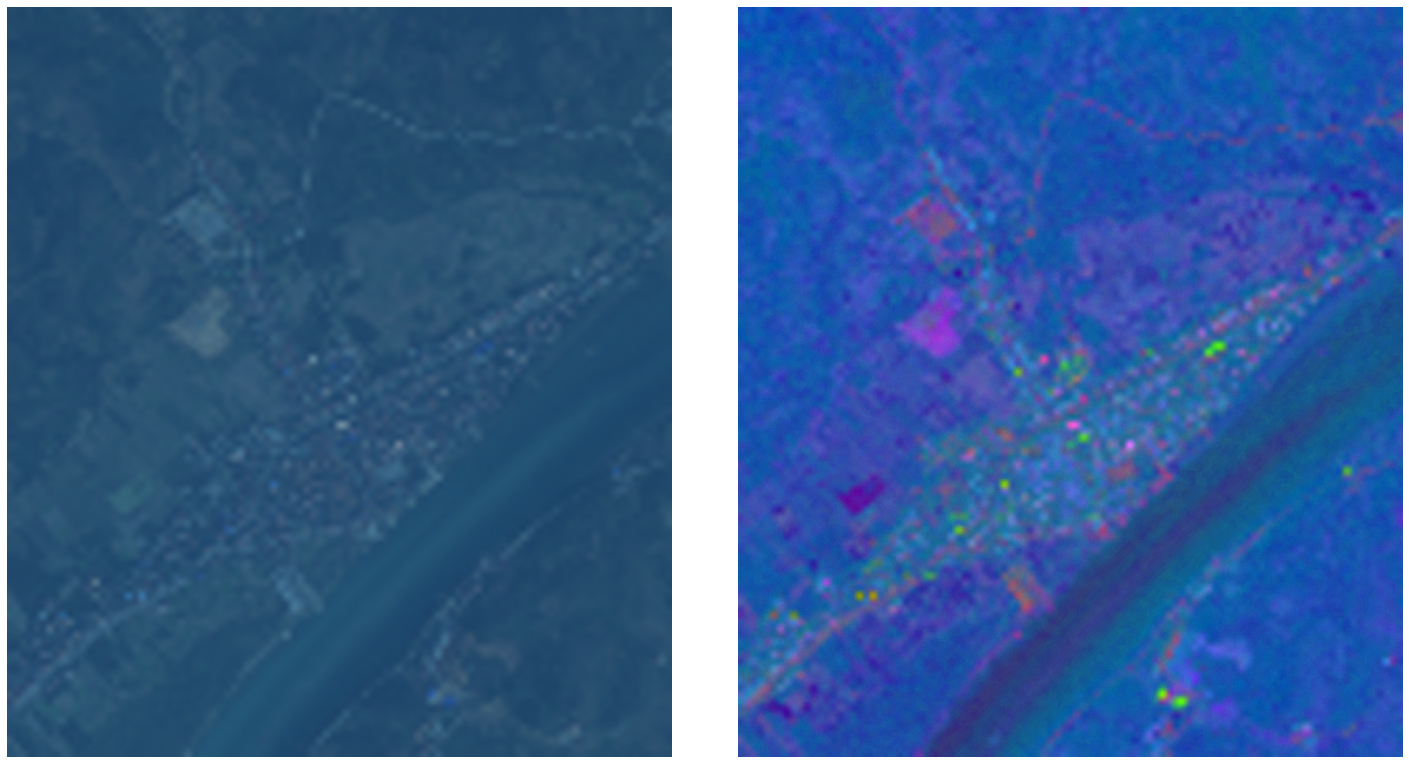

In [ ]:
#@title
# Comparsion of RGB and Image produced using first three bands
fig,axes = plt.subplots(1,2,figsize=(25,25),
                        sharex='all', sharey='all')   
fig.subplots_adjust(wspace=0.1, hspace=0.15)

axes[0].imshow(ms0[:,:,0:3].astype(int))
axes[0].axis('off');

axes[1].imshow(PC_2d_Norm[:,:,:3][:,:,[0,2,1]].astype(int))
axes[1].axis('off');

DWT on 1st coeff of PCA

In [ ]:
r,g,b = [c.T for c in PC_2d_Norm[:,:,:3][:,:,[0,2,1]].astype(int).T]

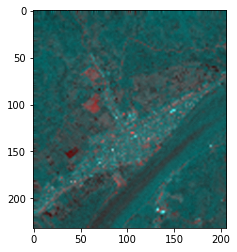

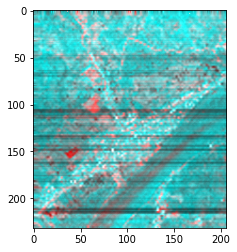

In [ ]:
n = 1
w = 'db5'
coeffsR = pywt.wavedec2(r,wavelet=w,level=n,mode='smooth')
cR = coeffsR.copy()
# normalize each coefficient Array
coeffsR[0] /= np.abs(coeffsR[0]).max()
for detail_level in range(n):
  coeffsR[detail_level + 1] = [d/np.abs(d).max() for d in coeffsR[detail_level]]

# plt.imshow(coeffsR[0], cmap='Reds')
# plt.show()
# plt.imshow(coeffsR[1], cmap='Reds')
# plt.show()

coeffsG = pywt.wavedec2(g,wavelet=w,level=n,mode='smooth')
cG = coeffsG.copy()
coeffsG[0] /= np.abs(coeffsG[0]).max()
for detail_level in range(n):
    coeffsG[detail_level + 1] = [d/np.abs(d).max() for d in coeffsG[detail_level]]
# plt.imshow(coeffsG[0],cmap='Greens')
# plt.show()
# plt.imshow(coeffsG[1],cmap='Greens')
# plt.show()

coeffsB = pywt.wavedec2(g,wavelet=w,level=n,mode='smooth')
cB = coeffsB.copy()
coeffsB[0] /= np.abs(coeffsB[0]).max()
for detail_level in range(n):
    coeffsB[detail_level + 1] = [d/np.abs(d).max() for d in coeffsB[detail_level]]
# plt.imshow(coeffsB[0],cmap='Blues')
# plt.show()
# plt.imshow(coeffsB[1],cmap='Blues')
# plt.show()

lowMS = (np.dstack((coeffsR[0],coeffsG[0],coeffsB[0]))*255.999).astype(np.uint8)
plt.imshow(lowMS)
plt.show()
hiMS = (np.dstack((coeffsR[-1],coeffsG[-1],coeffsB[-1]))*255.999).astype(np.uint8)
plt.imshow(hiMS)
plt.show()

MHT on PAN

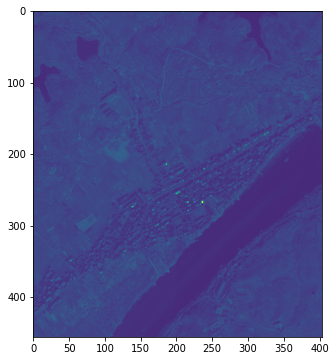

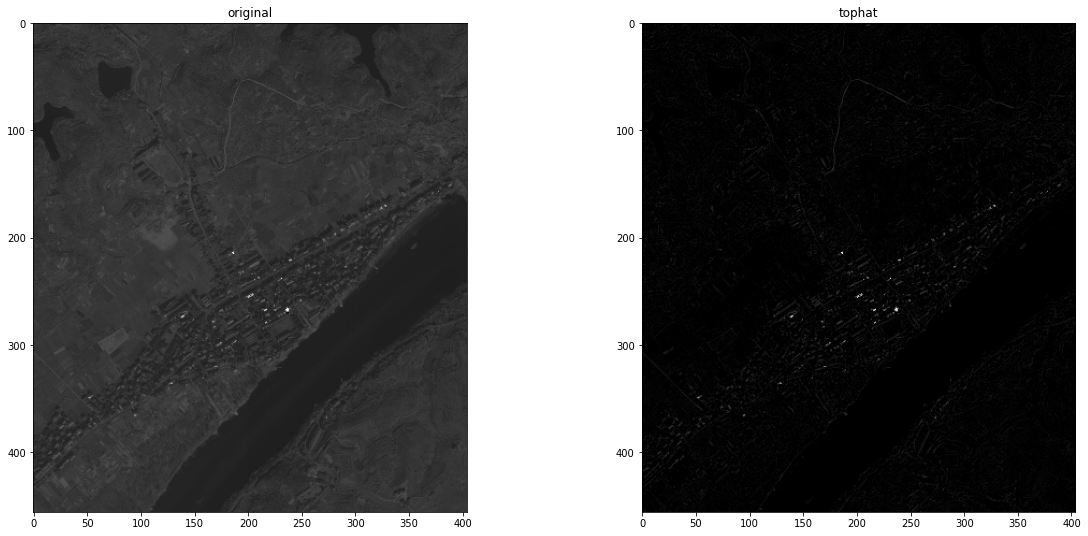

In [ ]:
# Importing OpenCV
import cv2
filterSize =(3, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_1.npy',None)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0)

morphed_img=[]
#input_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
tophat_img = cv2.morphologyEx(pan0,cv2.MORPH_TOPHAT,kernel)
morphed_img.append(tophat_img)


plt.figure(figsize=(20,9))
plt.subplot(121)
plt.title('original')    
plt.imshow( pan0,cmap='gray')
plt.subplot(122)
plt.title('tophat')
plt.imshow( morphed_img[0],cmap= 'gray')



In [ ]:
morphed_img[0].shape

(456, 404)

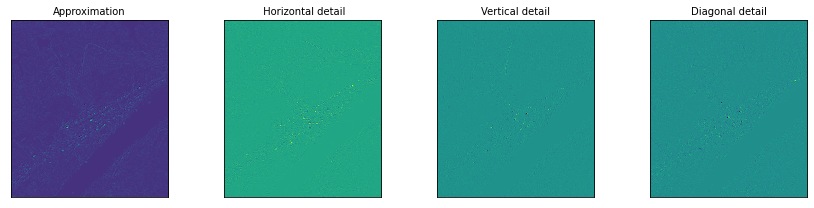

In [ ]:
# Load image
original = morphed_img[0]
w='db5'

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, w)
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest")
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

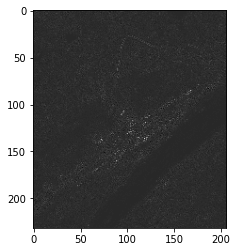

In [ ]:
lowPAN= np.maximum( LH, HL, HH)
plt.imshow(lowPAN,cmap='gray')

fusion of low coeff of PAN and MS

In [ ]:
lowMS= lowMS[:,:,0]
hiMS =hiMS[:,:,0]

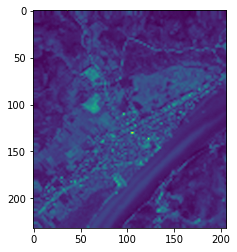

In [ ]:
low_fused_array= np.maximum(lowMS,lowPAN)
plt.imshow(low_fused_array)
plt.show()

fusion of high coeff of MS and PAN

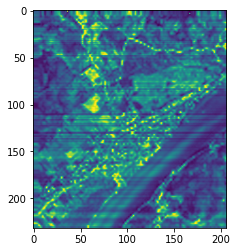

In [ ]:
high_fused_array= np.maximum(hiMS,LL)
plt.imshow(high_fused_array)
plt.show()

IDWT

In [ ]:
high_fused_array.shape, low_fused_array.shape

((232, 206), (232, 206))

In [ ]:
A = pywt.idwt(high_fused_array, None, 'db3', 'smooth')
D = pywt.idwt(low_fused_array, None, 'db3', 'smooth')
fused= A + D

In [ ]:
fused.shape

(232, 408)

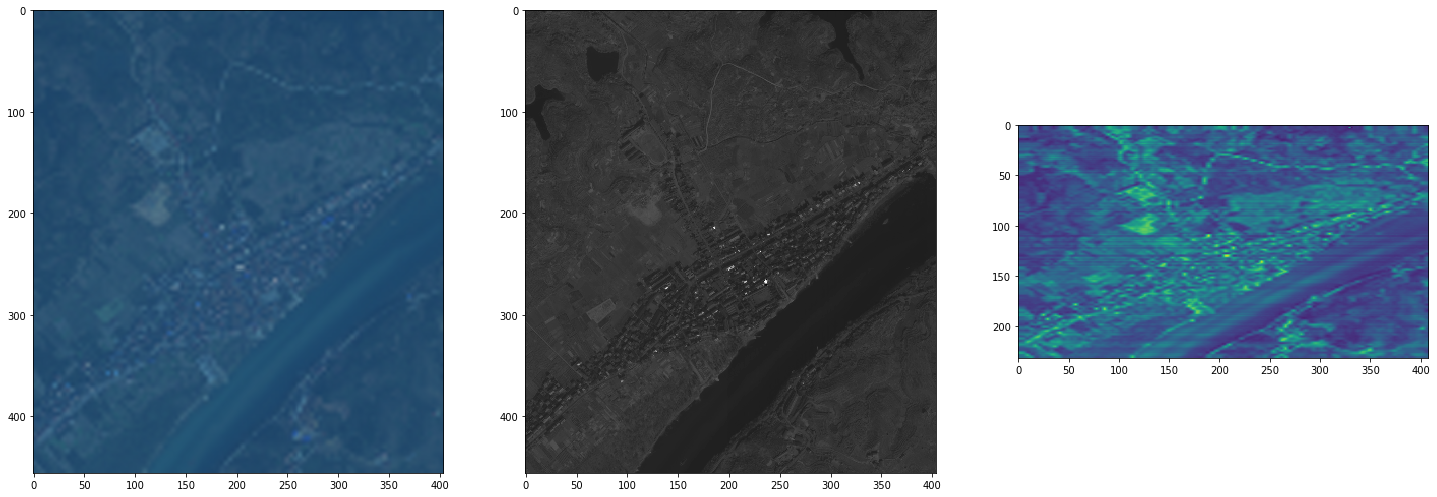

In [ ]:
fig6 = plt.figure(figsize=(25, 25))
ax = fig6.add_subplot(1, 3, 1)
ax.imshow(ms0, interpolation="nearest")
ax = fig6.add_subplot(1, 3, 2)
ax.imshow(pan0, interpolation="nearest", cmap ='gray')
ax = fig6.add_subplot(1, 3, 3)
ax.imshow(fused, interpolation="nearest")
plt.show()

In [ ]:
entropy = skimage.measure.shannon_entropy(pan0)
print(entropy)

5.112409952743356


In [ ]:
entropy = skimage.measure.shannon_entropy(ms0)
print(entropy)

6.048367664163774


In [ ]:
entropy = skimage.measure.shannon_entropy(fused)
print(entropy)

16.446317182830573


In [ ]:
print("STD_ms", ms0.std())
print("STD_pan", pan0.std())
print("STD_fused", fused.std())




STD_ms 30.77933581340622
STD_pan 0.07766504768759715
STD_fused 47.78582723069607


In [ ]:
#@title
from abc import abstractmethod
import numpy as np
from math import pi
from cv2 import cartToPolar, Sobel, CV_32F
from matplotlib.pyplot import imshow, title, show

class XideaPetrovicMetric():
    # xydeas_petrovic parameters
    # The constants Γ, κ , σ  and Γα, κα, σα determine 
    # the  exact  shape  of  the  sigmoid  functions  used  to  form  the  edge  strength  and  
    # orientation  preservation  values.
    def __init__(self, image1, image2, fusedImage) -> None:
        self.EPS = np.finfo(float).eps
        self.GAMMA1 = 1
        self.GAMMA2 = 1
        self.K1 = -10
        self.K2 = -20
        self.DELTA1 = 0.5
        self.DELTA2 = 0.75
        self.L = 1
        self.image1 = image1
        self.image2 = image2
        self.fusedImage = fusedImage

    def _sobel_edge_detection(self, image, verbose=False):
        sx = Sobel(image, CV_32F, 1, 0)
        sy = Sobel(image, CV_32F, 0, 1)

        if verbose:
            imshow(sx, cmap='gray')
            title("Horizontal Edge")
            show()

            imshow(sy, cmap='gray')
            title("Vertical Edge")
            show()

        return cartToPolar(sx, sy)

    def _strenght_n_orientation(self, image):
        #The first input is the source image, which we convert to float. 
        #The second input is the output image, but we'll set that to None as we want the function 
        # call to return that for us. 
        #The third and fourth parameters specify the minimum and maximum values 
        # you want to appear in the output, which is 0 and 1 respectively, 
        #and the last output specifies how you want to normalize the image.
        # What I described falls under the NORM_MINMAX flag.
        #image = normalize(image.astype('float'), None, 0.0, 1.0, NORM_MINMAX)  
        # Kernels for convolving over the images
        #flt1= [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
        #flt2= [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
        # 1) get the map Sobel operator
        #fuseX = filter2D(image, -1, flt1)
        #fuseY = filter2D(image, -1, flt2)
        #   EQUIVALENT TO:
        s_x, s_y = self._sobel_edge_detection(image)
        #fusex
        # A Sobel edge operator is applied to yield the edge strength G
        g = np.sqrt(s_x**2 + s_y**2)
        # Orientation α(n,m) information for each pixel p
        alpha = np.arctan(s_y / ( s_x + self.EPS))
        return (g, alpha)

    def _perceptual_loss(self, gA, gF, alphaA, alphaF):
        # If g o alpha are followed by an underscore are ment to be considered written in uppercase
        # The relative strength and orientation values of g_AF(n,m) and alpha_AF(n,m) of an input 
        # image A with respect to F are formed as:
        
        #x, y = gA.shape
        #g_AF = np.zeros((x,y))
        #for n in range(x):
        #    for m in range(y):
        #        if (gA[n][m]  > gF[n][m]):
        #            g_AF[n][m] = gF[n][m] / ( gA[n][m] + EPS)
        #        else:
        #            g_AF[n][m] = gA[n][m] / ( gF[n][m] + EPS)
        bmap0 = gA > gF
        bmap1 = gA < gF
        
        g_AF0 = np.divide(gF, ( gA + self.EPS))
        g_AF1 = np.divide(gA, ( gF + self.EPS))

        g_AF = np.multiply(bmap0, g_AF0) + np.multiply(bmap1, g_AF1)

        alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)

        qG_AF = self.GAMMA1 / (1 + np.exp( self.K1 *(g_AF - self.DELTA1)))
        qalpha_AF = self.GAMMA2 / (1 + np.exp( self.K2 *(alpha_AF - self.DELTA2) ))
        # These are used to derive the edge strength and orientation preservation values
        # QgAF(n,m)  and  QαAF(n,m)  model  perceptual  loss  of  information  in  F,  in  terms  of  
        # how well the strength and orientation values of a pixel p(n,m) in A are 
        # represented in the fused image. 
        #
        # Edge  information preservation values are then defined as
        q_AF = qG_AF * qalpha_AF
        # with  0  ≤  Q AF(n,m)  ≤  1 .  A  value  of  0  corresponds  to  the  complete  loss  of  edge  
        # information, at location (n,m), as transferred from A into F. QAF(n,m)=1 indicates 
        # “fusion” from A to F with no loss of information. 
        return q_AF

    def calculate(self):
        # EDGE Strenght and orientation for each pixels of the input images
        gA, alphaA = self._strenght_n_orientation(self.image1)
        gB, alphaB = self._strenght_n_orientation(self.image2)
        gF, alphaF = self._strenght_n_orientation(self.fusedImage)
        
        self.q_AF = self._perceptual_loss(gA, gF, alphaA, alphaF)
        self.q_BF = self._perceptual_loss(gB, gF, alphaB, alphaF)
        #
        # In general edge preservation values which 
        # correspond to pixels with high edge strength, should influence normalised weighted  
        # performance metric QP more than 
        # those of relatively low edge strength.Thus, wA(n,m)=[gA(n,m)]^L and 
        # wB(n,m)=[gB(n,m)]^L where L is a constant.
        #
        self.wA = gA #np.linalg.matrix_power(gA, L)
        self.wB = gB #np.linalg.matrix_power(gB, L)

        self.r = ( gF < gA ) | ( gF < gB )
        self.bitmap_artifacts = (gF > gA) & (gF > gB)

        return self.metric() #hook
    
    @abstractmethod
    def metric(self):
        pass

class InformationPreservation(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        qP_ABF = sum( sum((self.q_AF * self.wA + self.q_BF * self.wB))) / sum ( sum((self.wA + self.wB)))
        return qP_ABF

class TotalFusionGain(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    def metric(self):
        # local exclusive information in F, Q_delta
        # quantifies the total amount of local
        # exclusive information across the fused image.
    
        q_delta = np.abs(self.q_AF - self.q_BF)
    
        # For locations with strong correlation between the inputs Q_delta 
        # will be small or zero, indicating no exclusive
        # information. Conversely, in areas where one of the
        # inputs provides a meaningful feature that is not present
        # in the other this quantity will tend towards 1.

        # The common information component for all locations across the fused image
        q_common = (self.q_AF + self.q_BF  - q_delta) / 2
        # ½ is introduced as common information is contained in both Q_AF and Q_BF

        # Local estimates of exclusive information
        # components of each input
        q_delta_AF = self.q_AF - q_common
        # is the proportion of useful information fused in F that exists only in A
        q_delta_BF = self.q_BF - q_common
        # is the proportion of useful information fused in F that exists only in B

        # These quantities represent effectively, local fusion gain 
        # achieved by fusing A and B with respect to each individual {A, B}.
        
        # TOTAL FUSION GAIN
        return sum( sum((q_delta_AF * self.wA + q_delta_BF * self.wB))) / sum ( sum((self.wA + self.wB)))

class FusionLossArtifact(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        # if gradient strength in F is larger than
        # that in the inputs, F contains artifacts; conversely, a
        # weaker gradient in F indicates a loss of input
        # information.
        loss = np.multiply(1 - self.q_AF, self.wA) + np.multiply(1 - self.q_BF, self.wB)
        loss = np.multiply(loss, self.r)
        loss = sum( sum(loss)) / sum ( sum((self.wA + self.wB)))

        #Artifacts calculation
        
        artifacts = 2 - self.q_AF - self.q_BF
        artifacts = np.multiply(self.bitmap_artifacts, artifacts)
        artifacts = sum( sum(artifacts)) / sum ( sum((self.wA + self.wB)))

        return (loss, artifacts)


In [ ]:
fused = cv2.resize(fused, (404,456 ))
ms0 = ms0[:,:,0]

In [ ]:
#@title
InformationPreservation(pan0.astype('float32'), ms0.astype('float32'), fused.astype('float32')).calculate()

0.11130202435618644

In [ ]:
#@title
TotalFusionGain(pan0.astype('float32'), ms0.astype('float32'), fused.astype('float32')).calculate()

0.11102299100880277

In [ ]:
#@title
FusionLossArtifact(pan0.astype('float32'), ms0.astype('float32'), fused.astype('float32')).calculate()

(0.01397313805833352, 0.1256984055889159)

In [ ]:
#@title
def PSNR(ms0, result1):
    r= np.array(result1)
    print(ms0.shape)
    
    mse = np.mean((ms0 - r) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
    print (psnr)

In [ ]:
#@title
PSNR(ms0,fused)

(456, 404)


11.41036819002979

In [ ]:
#@title
PSNR(pan0,fused)

(456, 404)


7.7292940870453

Text(0, 0.5, 'T2 signal bin')

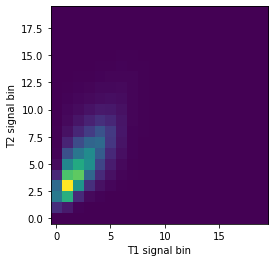

In [ ]:
#@title
hist_2d, x_edges, y_edges = np.histogram2d( ms0.ravel(),fused.ravel(),bins=20)
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

Text(0, 0.5, 'T2 signal bin')

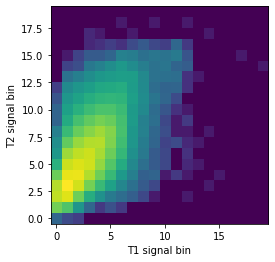

In [ ]:
#@title
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')

plt.xlabel('T1 signal bin')

plt.ylabel('T2 signal bin')


In [ ]:
#@title
def mutual_information(hgram):
  # Convert bins counts to probability values
  pxy = hgram / float(np.sum(hgram))
  px = np.sum(pxy, axis=1) # marginal for x over y
  py = np.sum(pxy, axis=0) # marginal for y over x
  px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
     # Now we can do the calculation using the pxy, px_py 2D arrays
  nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
  return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [ ]:
#@title
mutual_information(hist_2d)

0.3144039444112392

Text(0, 0.5, 'T2 signal bin')

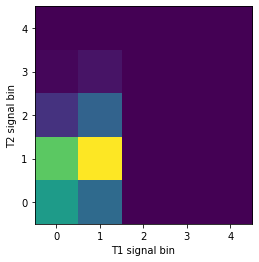

In [ ]:
#@title
hist_2d, x_edges, y_edges = np.histogram2d(pan0.ravel(),fused.ravel(),bins=5)
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

Text(0, 0.5, 'T2 signal bin')

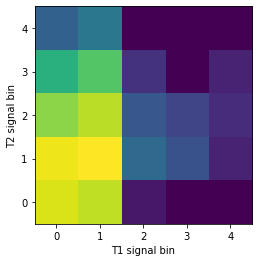

In [ ]:
#@title
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')

plt.xlabel('T1 signal bin')

plt.ylabel('T2 signal bin')

In [ ]:
#@title
mutual_information(hist_2d)

0.023001388617314412